### Introduction
This notebook was prepared to analyze the public dataset "Airplane Crashes and Fatalities Since 1908", hosted by Open Data by Socrata, and available for download from this URL: https://www.kaggle.com/saurograndi/airplane-crashes-since-1908.

It explores some hypothesis regarding flight safety in today's perspective and proceeds on building an ML model on a given topic (which depends on further understanding of the dataset).

### 0. Data Exploration 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import Counter

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 200)

In [3]:
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [4]:
# util function
def na_stats(df):
    """
    Displays the number of not null values per column.
    """
    total_len = len(df)
    date_notnull = len(df[df.date.notnull()])
    time_notnull = len(df[df.time.notnull()])
    loc_notnull = len(df[df.location.notnull()])
    oper_notnull = len(df[df.operator.notnull()])
    route_notnull = len(df[df.route.notnull()])
    type_notnull = len(df[df.type.notnull()])
    aboard_notnull = len(df[df.aboard.notnull()])
    fatal_notnull = len(df[df.fatalities.notnull()])
    ground_notnull = len(df[df.ground.notnull()])
    summ_notnull = len(df[df.summary.notnull()])

    print('total_len: ',total_len)
    print('date_notnull: ',date_notnull)
    print('time_notnull: ',time_notnull)
    print('loc_notnull: ',loc_notnull)
    print('oper_notnull: ',oper_notnull)
    print('route_notnull: ',route_notnull)
    print('type_notnull: ',type_notnull)
    print('aboard_notnull: ',aboard_notnull)
    print('fatal_notnull: ',fatal_notnull)
    print('ground_notnull: ',ground_notnull)
    print('summ_notnull: ',summ_notnull)

def plot_max_month(df):
    crashes_per_year = Counter(df['year'])
    years = list(crashes_per_year.keys())

    months_covered = []
    for i in years:
        months_covered.append(max(df[df.year == i].month))

    grid = plt.figure(figsize=(14, 10))
    grid = sns.barplot( x=years, y=months_covered, color='b')
    grid.set(ylabel="Month", xlabel="Year", title="Max Month In Dataset")
    grid.set_xticklabels(grid.get_xticklabels(),rotation=70, fontsize=10)
    plt.show()
    
def plot_crash(df):
    """
    Plot number of aircraft crashes 
    """
    crashes_per_year = Counter(df['year'])
    years = list(crashes_per_year.keys())
    crashes_year = list(crashes_per_year.values())
    
    print('Total number of crashes: ',len(df))
    print('Min year: ',min(years))
    print('Max year: ',max(years))
    
    grid = plt.figure(figsize=(14, 10))
    grid = sns.barplot( x=years, y=crashes_year, color='g')
    grid.set(ylabel="Crash", xlabel="Year", title="Plane crashes per year")
    grid.set_xticklabels(grid.get_xticklabels(),rotation=70, fontsize=10)
    plt.show()

def plot_fatal(df, begin=1908, end=2009):
    """
    Plot number of passenger fatalities on aircrafts.
    """
    df_tmp = df[['year','fatalities']].copy()
    plt.figure(figsize=(20, 6))
    plt.plot(df_tmp.groupby('year').sum())
    plt.title(f'Fatalities per year ({begin}-{end})')
    plt.xlabel('Year')
    plt.ylabel('Fatalities')
    plt.xlim([begin, end])
    
def plot_passenger(df):
    """
    Plots number of passengers on airplanes from 1970 to 2009
    """
    plt.figure(figsize=(14, 10))
    plt.plot(df)
    plt.xticks(rotation=70)
    plt.show()    
    
def process_worldbank():
    """
    Download and preprocess worldbank data
    """
    # download data
    df = pd.read_csv('worldbank/API_IS.AIR.PSGR_DS2_en_csv_v2_673046.csv', skiprows=4)
    
    # cleaning data, and aggregating it so that we have count of passengers for each year from 1970 to 2009.
    df = df.drop(['Country Name', 'Country Code', 'Indicator Name','Indicator Code'], axis=1)
    df = pd.DataFrame({'passengers':df.sum(axis=0)})
    df = df[df.passengers > 0]
    df = df[:40] # limit data up to 2009
    return df

In [5]:
data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

In [6]:
data.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


Most of the fields from the dataset are pretty self-explanatory, however some like `Ground` and `cn/ln` are rather vague.

From data.world (https://data.world/data-society/airplane-crashes/discuss/mqytenrq#wzyiq7ck), we learn that `Ground` stands for the amount of death on the ground, while `cn/ln` is the manufacturer's serial number.

In [7]:
# renaming the column for simplicity
new_col_name = ['date','time','location','operator','flight_num','route','type','registration','cn_ln','aboard','fatalities','ground','summary']
data.columns = new_col_name

In [8]:
data.head()

,date,time,location,operator,flight_num,route,type,registration,cn_ln,aboard,fatalities,ground,summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


The many fields provided in the dataset gives us a few lense that we can use to understand the data. 

Fields suchs as `flight_num`,`cn_ln` and `registration` however - wouldn't give us that much information. Hence we'll proceed to remove them from our analysis.

In [9]:
data = data.drop(['flight_num', 'registration', 'cn_ln'], axis=1)

We now look at the completeness of the dataset, to understand whether the fields that we have are reliable or not for us to make assumptions with.

In [10]:
na_stats(data)

total_len:  5268
date_notnull:  5268
time_notnull:  3049
loc_notnull:  5248
oper_notnull:  5250
route_notnull:  3562
type_notnull:  5241
aboard_notnull:  5246
fatal_notnull:  5256
ground_notnull:  5246
summ_notnull:  4878


Looks like all the columns are usable.

Next we look at introducting some new features from existing fields. Some of the obvious ones are:
1. Year
2. Month
3. Day

In [11]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].map(lambda x: x.year)
data['month'] = data['date'].map(lambda x: x.month)
data['day'] = data['date'].map(lambda x: x.day)

#### Should we include 2009?

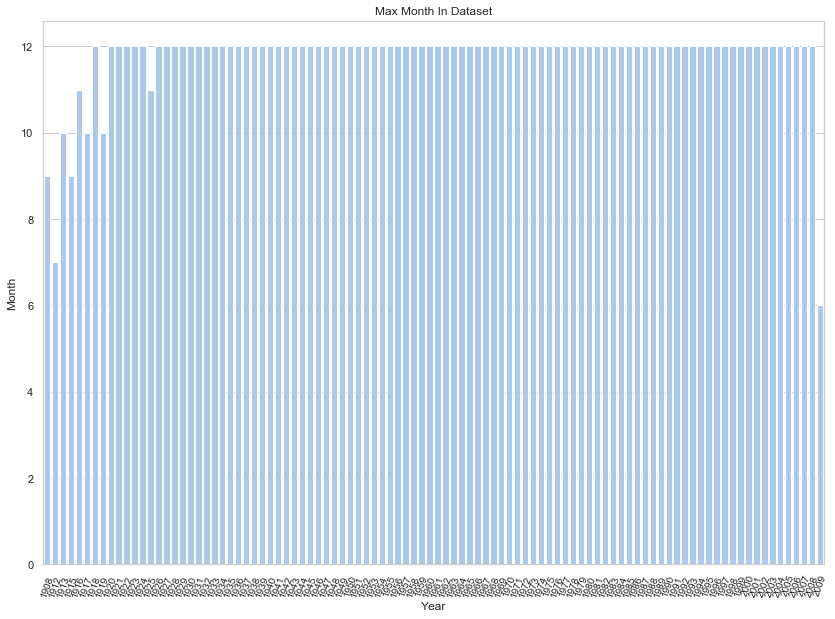

In [12]:
plot_max_month(data)

The above shows that in most years crashes happen up to December, but 2009 has only up to June. This imply that the dataset itself was last updated for data up to June 2009, hence we should disregard the year 2009 when making our analysis.

In [13]:
data = data[data.date < '2009']
max(data.date)

Timestamp('2008-12-15 00:00:00')

#### Commercial VS Military

Total number of crashes:  5244
Min year:  1908
Max year:  2008


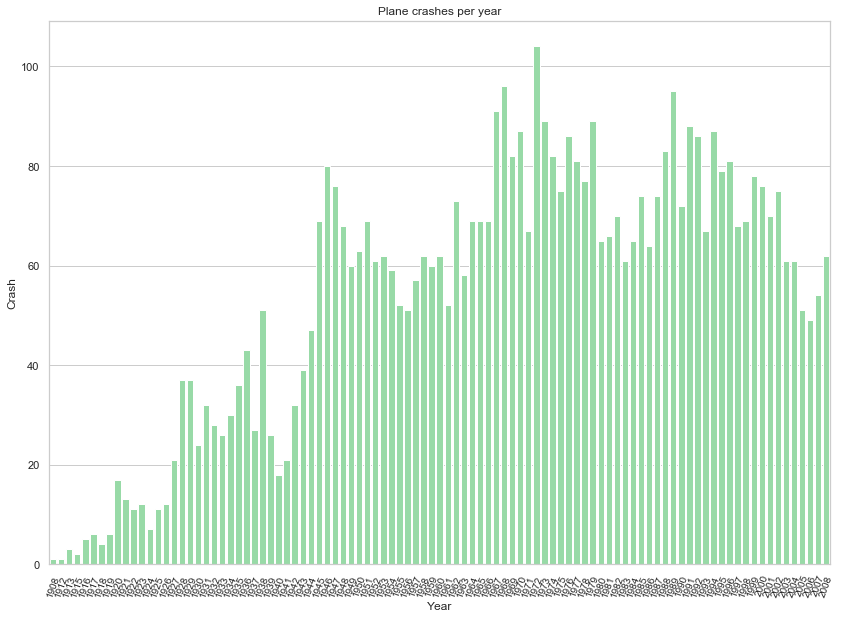

In [14]:
plot_crash(data)

Looking at the above diagram, it would appear that airline crashes have peaked at around 1970, and slowly decrease up to 2009. 

Circling back to our original question, is is safer to board a flight nowadays? Assuming that we are talking about civilians, it is reasonable then to exclude data points that belongs to military activities and private flights. Let's look deeper into the distribution of flight types in our data.

In [15]:
# unique operators
len(data.operator.unique())

2461

In [16]:
data['operator'] = data.operator.astype('str')

In [17]:
# define flight type
data['flight_type'] = 'unknown' 
data.loc[(data['operator'].str.contains('Military')),'flight_type'] = 'military'
data.loc[(data['operator'] == 'Private'),'flight_type'] = 'others'
data.loc[(data['operator'] == 'US Aerial Mail Service'), 'flight_type'] = 'others'

In [18]:
# check for other types of flight types randomly.
vals = data[(data['operator'].str.contains('Air')) & (data.flight_type == 'unknown')].operator
random_values = random.sample(set(vals), 200)
random_values[:5] # we look at 200 random entries

['Alaska International Air',
 'Avtex Air Services',
 'Orient Airways',
 'Air Martinique',
 'Baikal Air']

Seems that there are essentially just 2 types of flight in the dataset, `military` and `commercial`. We have also added an `others` category to contain flights from private aircraft and the US Mail.

Let's assign all the `unknown` flight types to `commercial`.

In [19]:
data.loc[data['flight_type'] == 'unknown','flight_type'] = 'commercial'
data_comm = data[data.flight_type == 'commercial']
data_comm.head()

,date,time,location,operator,route,type,aboard,fatalities,ground,summary,year,month,day,flight_type
24,1919-10-02,NaN,"Newcastle, England",Aircraft Transport and Travel,NaN,De Havilland DH-4,1.0,1.0,0.0,NaN,1919,10,2,commercial
26,1919-10-20,NaN,English Channel,Aircraft Transport and Travel,NaN,De Havilland DH-4,NaN,NaN,NaN,NaN,1919,10,20,commercial
34,1920-08-16,NaN,"Bedford, England",By Air,NaN,Armstrong-Whitworth F-K-8,1.0,1.0,0.0,NaN,1920,8,16,commercial
39,1920-10-02,NaN,"Off Port Vendres, France",Latecoere Airlines,NaN,Salmson 2-A-2,2.0,2.0,0.0,NaN,1920,10,2,commercial
40,1920-10-05,NaN,"Valencia, Spain",Latecoere Airlines,NaN,Breguet 14,2.0,2.0,0.0,Crashed while landing.,1920,10,5,commercial


Now that we've cleaned our data, let's proceed with the analysis

### 1. Analysis
TASK: Justify whether it is safer to take the aircraft nowadays. Support your decision with data.

Total number of crashes:  4400
Min year:  1919
Max year:  2008


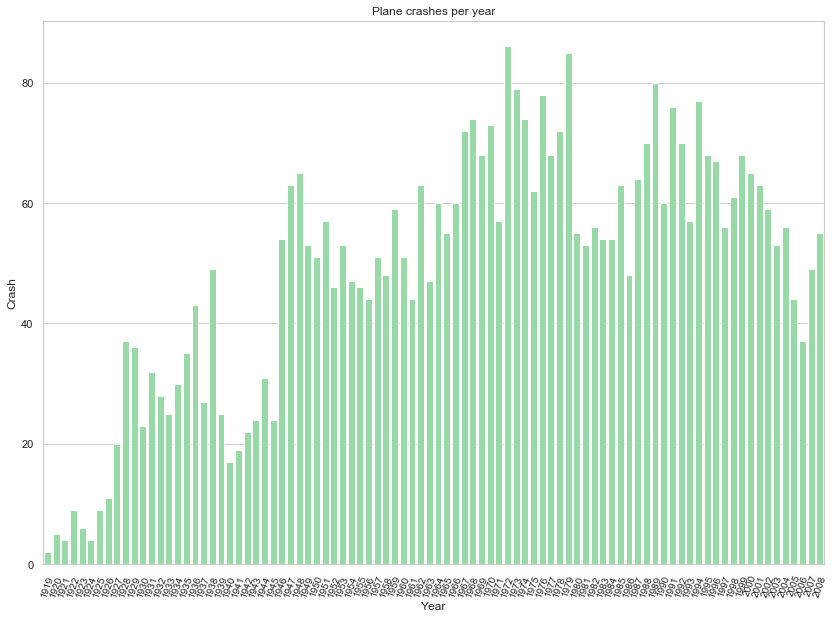

In [20]:
plot_crash(data_comm)

It would seem that it is indeed true that there are now lesser crashes since 1970s. 

Let's now look at the fatalities over the year.

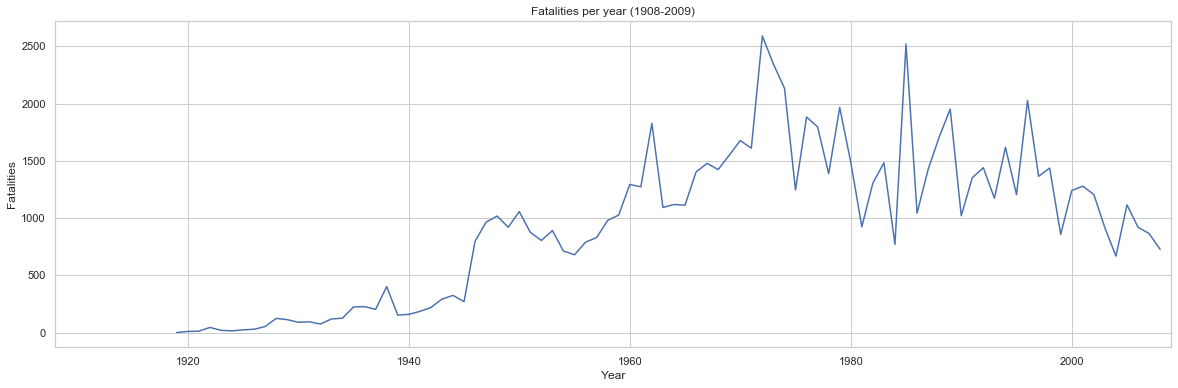

In [21]:
# fatalities for all period
plot_fatal(data_comm)

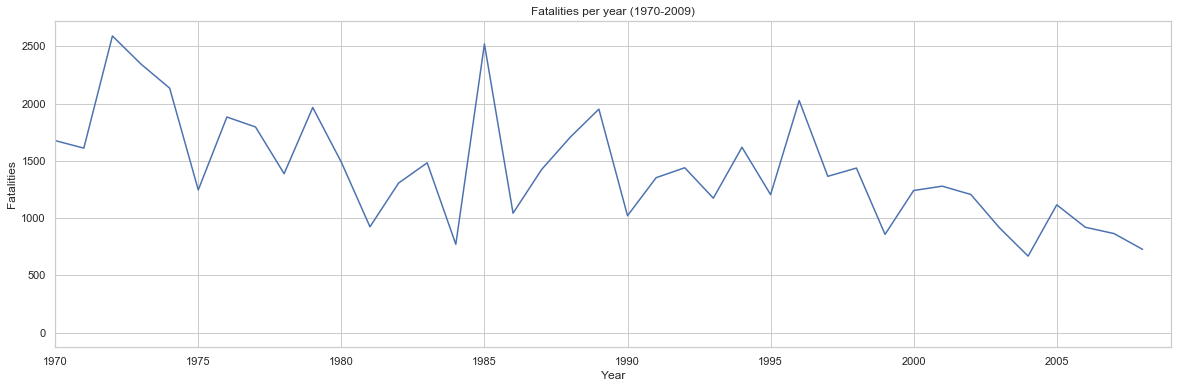

In [22]:
# fatalities from 1970
plot_fatal(data_comm,1970,2009)

Based on the above plots; we see a decline in passengers death over the years since 1970 to 2009.

As a comparison, let us also download an extra dataset from the Worldbank, to look at the total number of passengers carried over the same period.

URL: https://data.worldbank.org/indicator/IS.AIR.PSGR?end=2008&start=1970&view=chart

In [23]:
wb_data = process_worldbank()

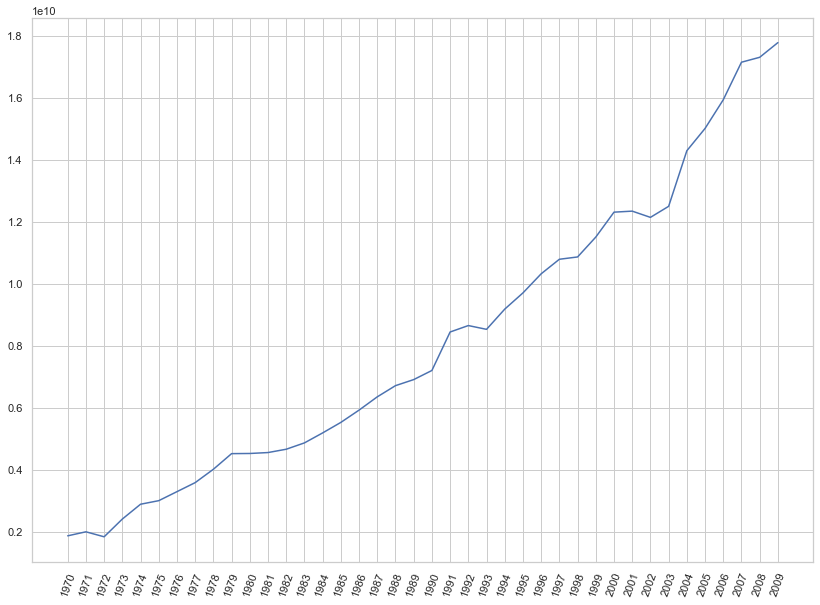

In [24]:
plot_passenger(wb_data)

The above demonstrates a steep increase in aircraft passengers from 0.2 billion in 1970 to about 1.8 billion in 2009.

Let's check for correlation between the two sets of numbers.

In [25]:
# prepare data for correlation analysis
## prepare fatalities
df_tmp = data_comm[['year','fatalities']].copy()
df_tmp = df_tmp.groupby('year', as_index=False).sum()
df_tmp['year'] = df_tmp.year.astype('str')

## prepare passengers
wb_tmp = wb_data.copy()
wb_tmp['year'] = wb_tmp.index.astype('str')
wb_tmp.reset_index(inplace=True)
wb_tmp = wb_tmp.drop(['index'],axis=1)

## merge
df = pd.merge(wb_tmp, df_tmp, how='left', on='year')
df = df[['year','passengers','fatalities']]

# get correlation
df['passengers'].corr(df['fatalities'])

-0.6070368400462807

What this means is that the 2 features are somewhat negatively correlated.

It means that as the number of passenger keep on increasing, we'll see that the number of fatalities will keep decreasing, but not by the same proportion.

#### Conclusion
We started this analysis by looking at the trend of airplane crashes overtime since 1908. We conclude that the rate has been steadily decreasing since 1970.

Then we looked at the number of fatalities that occured in those crashes. We note that the number has been steadily declining as well since 1970.

We then looked at the amount of passengers that has been travelling over the years since 1970, to see whether there is a correlation between the number of passengers travelling and the number of fatalities recorded. We discovered that there is a negative correlation between the 2 records, which meant that as the number of passengers keep on increasing, we expect to see a decrease in the number of fatalities.

Based on the facts above, we conclude that it is indeed safer to take the aircraft nowadays.

### 2. Machine Learning
TASK: Apply machine learning technique to predict any interesting topic of this.

#### Introduction
For this task I've decided to take a look at the causes of the flight crashes. 

#### Methodology
Instead of analyzing the text manually using a text lexicon (ie. counting frequency of keywords such as `engine failure`, `weather` or `show down`), we'll be using doc2vec to vectorize the text and use K-means to cluster the vectors according to their topic similarity.

To assess the accuracy of the model, we're going to visually inspect each cluster (this is an unsupervised training after all) that was trained on the training set. Further tweaks will need to be made based on the results.

Following an acceptable model, we'll proceed to further test the model using the test dataset, to see how the each cluster classification holds up against the new unseen data.

In [26]:
import nltk, math
import re
import os
import gensim

from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from nltk.cluster.kmeans import KMeansClusterer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

NEW_STOP_WORDS = ['crashed','aircraft','plane','flight']
NUM_CLUSTERS=6 # since we don't know the optimal number of K, let's first set this to 6.
MODEL_FN = 'airplane-crash-doc2vec.model'

stop_words = stopwords.words('english')
stop_words.extend(NEW_STOP_WORDS)
stop_words = set(stop_words)


In [27]:
# utils
def read_corpus(fname, tokens_only=False):
    for i, line in enumerate(fname):
        tokens = gensim.utils.simple_preprocess(line)
        tokens = [w for w in tokens if not w in stop_words]
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            
def preprocess_document(text):
    return ''.join([x if x.isalnum() or x.isspace() else " " for x in text ]).split()

def get_titles_by_cluster(id):
    list = []
    for x in range(0, len(assigned_clusters)):
        if (assigned_clusters[x] == id):
            list.append(used_lines[x])
    return list

def get_topics(titles):
    from collections import Counter
    words = [preprocess_document(x) for x in titles]
    words = [word for sublist in words for word in sublist]
    filtered_words = [word for word in words if word not in stop_words]
    count = Counter(filtered_words)
    print(count.most_common()[:5])


def cluster_to_topics(id):
    get_topics(get_titles_by_cluster(id))
    
def plotScatter(keyword, df_dx, tsne_df):
    fig = plt.figure(figsize=(10,15))
    ax = fig.add_subplot(1, 1, 1)

    pos_found_x = []
    pos_found_y = []
    found_names = []

    pos_rest_x = []
    pos_rest_y = []

    for term_id, pos in tsne_df.iterrows():
        term_name = df_dx[df_dx.index == term_id]['summary'].values[0].lower()

        if keyword in term_name:
            pos_found_x.append(pos['x'])
            pos_found_y.append(pos['y'])
        else:
            pos_rest_x.append(pos['x'])
            pos_rest_y.append(pos['y']) 

    ax.scatter(pos_rest_x, pos_rest_y, c='blue')       
    ax.scatter(pos_found_x, pos_found_y, c='red')

def infer_vector(data):
    print("Inferring vectors")
    vectors = []
    duplicate_dict = {}
    used_lines = []
    for i, t in enumerate(data):
        t = t.lower()
        if t not in duplicate_dict:
            duplicate_dict[t] = True
            used_lines.append(t)
            vectors.append(model.infer_vector(preprocess_document(t)))

    print("Done")
    return vectors, duplicate_dict, used_lines

In [28]:
# create train and test file.
data_comm = data_comm[data_comm.summary.notnull()]
summary = data_comm.summary

# split 30% as test set and use the rest as train
train, test = train_test_split(summary, shuffle=False, random_state=42, test_size=0.30)

print(train.shape)
print(test.shape)

(2865,)
(1229,)


In [29]:
train_corpus = list(read_corpus(train))
test_corpus = list(read_corpus(test, tokens_only=True))

#### Training the model

We make use of gensim library to train the model using `doc2vec`

In [30]:
# define model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=10, epochs=40)

# build vocab
model.build_vocab(train_corpus)

# train the model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

# save model
model.save(MODEL_FN)

#### Load model and apply K-Means

In [31]:
model = Doc2Vec.load(MODEL_FN)

In [32]:
vectors, duplicate_dict, used_lines = infer_vector(train)

Inferring vectors
Done


In [55]:
# apply K-means
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)

In [56]:
train_cluster = pd.DataFrame({'summary':used_lines, 'cluster':assigned_clusters})

In [57]:
cluster_no = 0
print('Cluster size: ',len(train_cluster[train_cluster.cluster == cluster_no]))
cluster_to_topics(cluster_no)

Cluster size:  428
[('mountain', 199), ('pilot', 157), ('weather', 119), ('route', 107), ('altitude', 104)]


In [58]:
cluster_no = 1
print('Cluster size: ',len(train_cluster[train_cluster.cluster == cluster_no]))
cluster_to_topics(cluster_no)

Cluster size:  254
[('engine', 218), ('fuel', 142), ('failure', 104), ('landing', 88), ('engines', 75)]


In [59]:
cluster_no = 2
print('Cluster size: ',len(train_cluster[train_cluster.cluster == cluster_no]))
cluster_to_topics(cluster_no)

Cluster size:  378
[('approach', 303), ('runway', 259), ('landing', 163), ('pilot', 137), ('crew', 111)]


In [60]:
cluster_no = 3
print('Cluster size: ',len(train_cluster[train_cluster.cluster == cluster_no]))
cluster_to_topics(cluster_no)

Cluster size:  1193
[('engine', 188), ('failure', 174), ('pilot', 162), ('cargo', 145), ('takeoff', 140)]


In [61]:
cluster_no = 4
print('Cluster size: ',len(train_cluster[train_cluster.cluster == cluster_no]))
cluster_to_topics(cluster_no)

Cluster size:  259
[('fire', 92), ('landing', 54), ('crew', 53), ('pilot', 51), ('en', 45)]


In [62]:
cluster_no = 5
print('Cluster size: ',len(train_cluster[train_cluster.cluster == cluster_no]))
cluster_to_topics(cluster_no)

Cluster size:  212
[('pilot', 96), ('runway', 82), ('takeoff', 75), ('crew', 68), ('control', 58)]


The above excerpts highlights a few topics for the clusters:
1. Cluster 0 : Mountain
2. Cluster 1 : Engine failure
3. Cluster 2 : Crash at runway (landing/approaching)
4. Cluster 3 : Engine failure
5. Cluster 4 : Fire
6. Cluster 5 : Crash at runway (takeoff)


Many of topic seem to overlap each other. Let's look at the cluster visually.

In [45]:
doc_tags=list(range(len(train_corpus)))
X = model[doc_tags]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

In [46]:
df_summary = pd.DataFrame(train).reset_index()[['summary']]

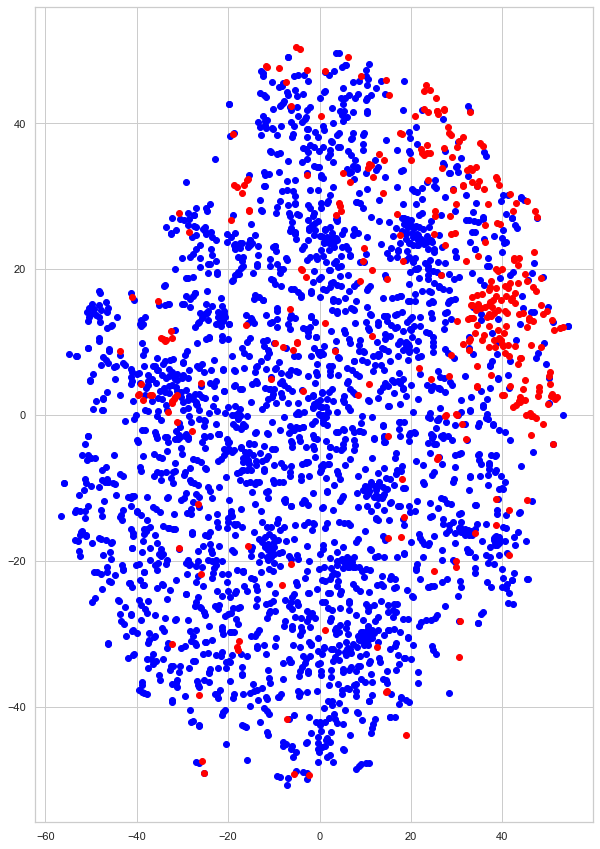

In [47]:
plotScatter(keyword='weather',df_dx= df_summary, tsne_df=df)

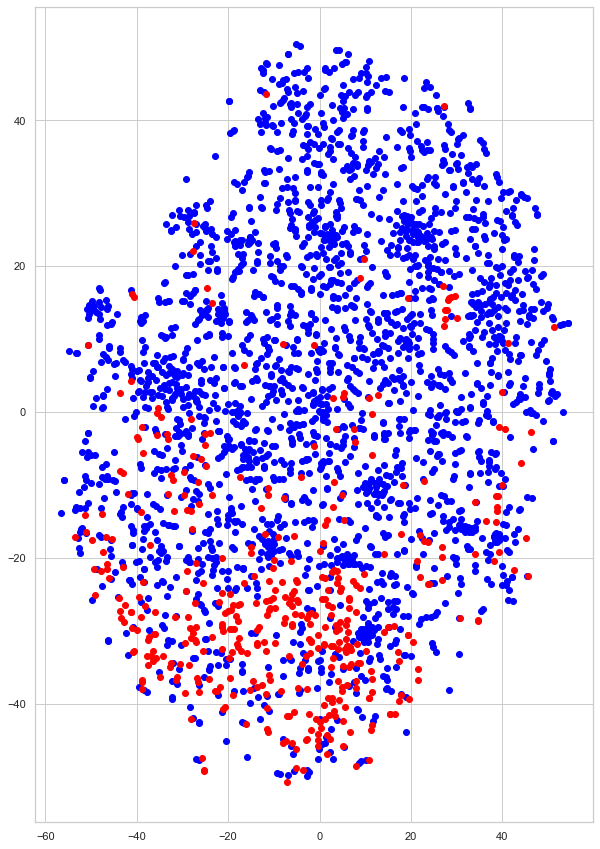

In [48]:
plotScatter(keyword='engine',df_dx= df_summary, tsne_df=df)

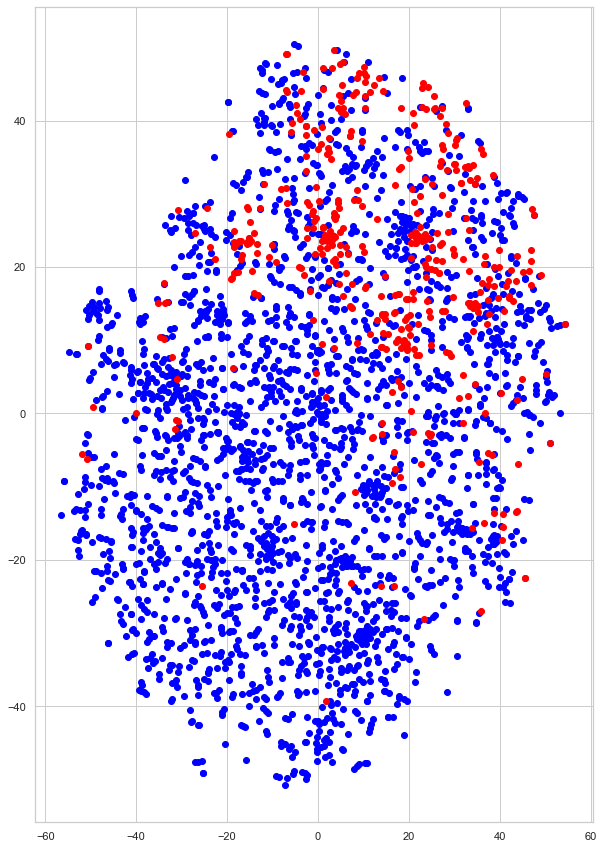

In [49]:
plotScatter(keyword='mountain',df_dx= df_summary, tsne_df=df)

Based on the above result, we see that our clusters aren't that good. 

1. Use more stopwords to clean the clusters
2. Use less clusters (or combine existing ones)
3. Retrain the model using better hyperparameters.

#### Applying model to test dataset

(to be done)